In [1]:
import pandas as pd
import pypsa      
import matplotlib.pyplot as plt
import plotly
import atlite
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd
import os
import matplotlib
# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

In [34]:
iso = "vn"

In [38]:
# Define run 
# run = "id_test/"
run = f"/{iso}_test/"
wdir = os.getcwd()
networks = wdir + "/networks/"  + run 
resources = wdir  + "/resources/" + run
shapes = resources + "/shapes/"

country_iso = {
    "ph":"Philippines",
    "th":"Thailand",
    "id":"Indonesia",
    "my":"Malaysia",
    "vn":"Vietnam"
}
country = country_iso[run[1:3]]

In [39]:
e = pypsa.Network( networks + "elec_s.nc")
capacity = e.generators[["carrier","p_nom"]].groupby("carrier").sum("capacity") / 1000
e.generators[['carrier','efficiency','marginal_cost', 'capital_cost']].groupby("carrier").mean()

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units


,efficiency,marginal_cost,capital_cost
carrier,,,
CCGT,0.58,38.855172,99027.729293
OCGT,0.41,53.524390,45095.441515
biomass,0.47,14.893617,278083.065356
coal,0.33,28.196970,349976.553630
lignite,0.33,12.287879,349976.553630
oil,0.35,148.857143,37870.807407
onwind,1.00,0.015000,96085.888020
ror,0.90,0.000000,299140.224929
solar,1.00,0.010000,35602.071244


In [40]:
n = pypsa.Network(networks + "elec_s_40_ec_lcopt_Co2L-3H.nc")

INFO:pypsa.io:Imported network elec_s_40_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


<AxesSubplot:xlabel='carrier'>

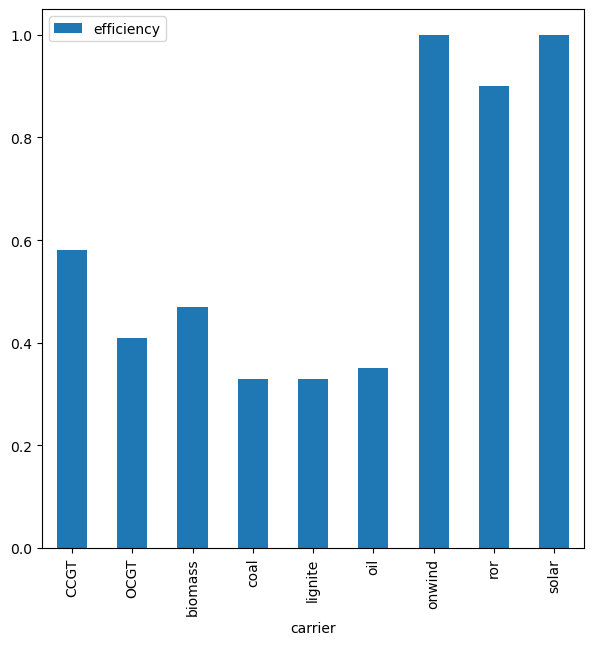

In [41]:
e.generators[["carrier","efficiency"]].groupby("carrier").mean().plot(kind="bar")

<AxesSubplot:xlabel='carrier'>

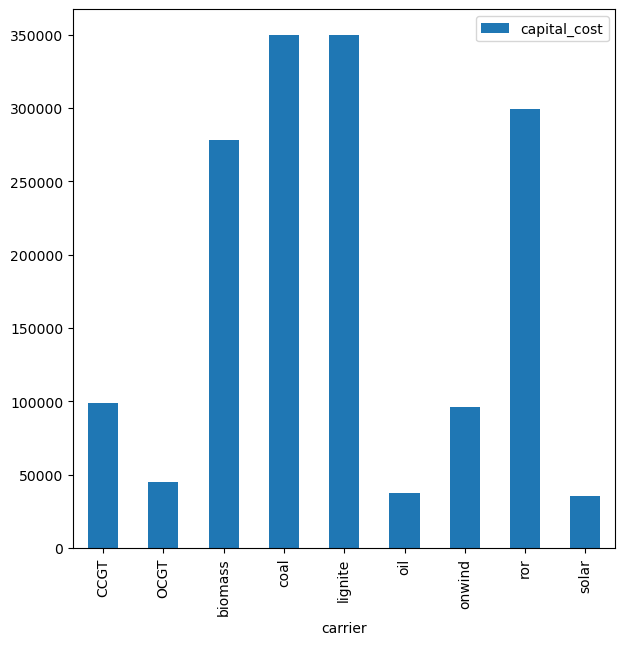

In [42]:
e.generators[["carrier","capital_cost"]].groupby("carrier").mean().plot(kind="bar")

<AxesSubplot:xlabel='carrier'>

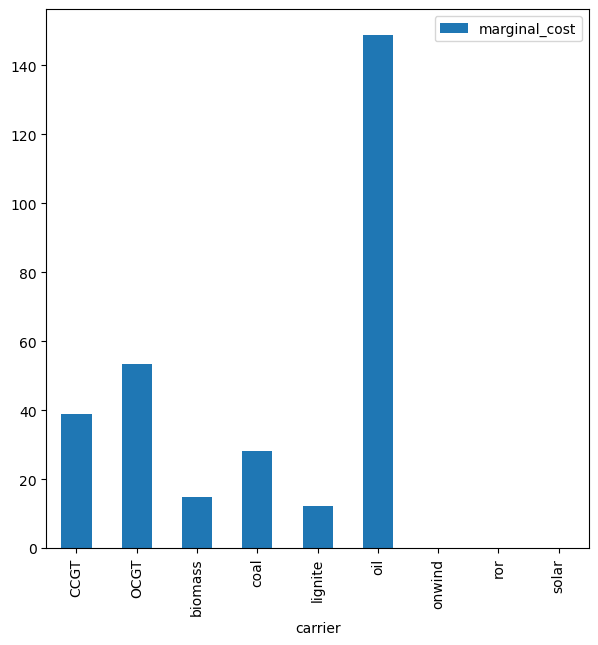

In [43]:
e.generators[["carrier","marginal_cost"]].groupby("carrier").mean().plot(kind="bar")

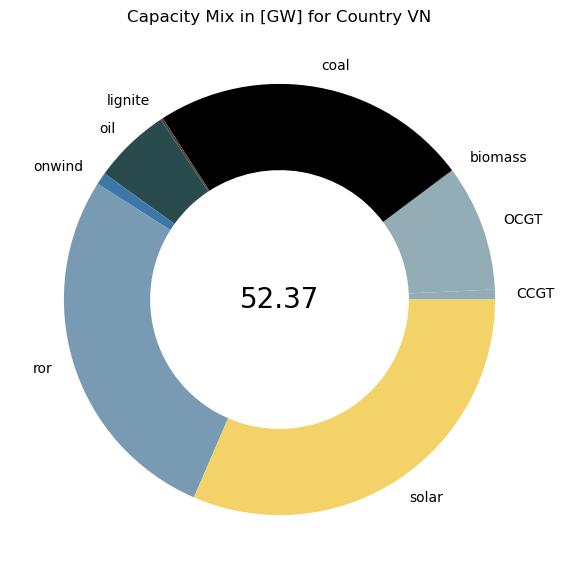

In [47]:

# Define data
values = capacity["p_nom"].values
labels = capacity.index
colourdict = {
    "coal":"#000000",
    "CCGT": "#92ADB5",
    "geothermal":"#CF5E8B",
    "oil":"#2A4B4D",
    "onwind":"#3D77A8",
    "ror":"#789AB2",
    "solar":"#F3D367",
    "OCGT":"#92ADB5",
    "biomass":"#4A6B4E",
    "lignite":"#533C37"
}
colours = [colourdict[carrier] for carrier in capacity.index]
# Create a pie chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=colours, wedgeprops={'width': 0.4})

# Add legend
# ax.legend(labels, loc='center')

# Add number in the centre of the donut
total = round(sum(values), 2)
ax.text(0, 0, total, ha='center', va='center', fontsize=20)

# Set title
ax.set_title("Capacity Mix in [GW] for Country " + e.buses.country.unique()[0])

# Show plot
plt.show()

<AxesSubplot:ylabel='GW'>

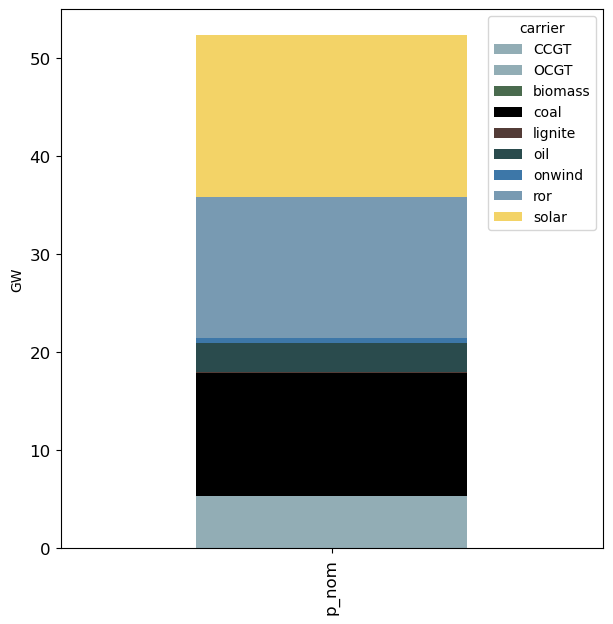

In [45]:
capacity.T.plot(kind="bar",stacked=True,color=colours,ylabel="GW",fontsize=12)

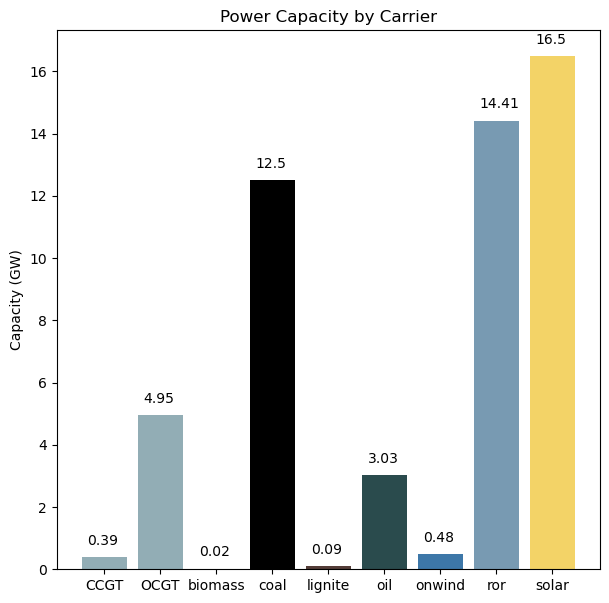

In [46]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create a bar chart
x_pos = np.arange(len(capacity.index))
ax.bar(x_pos, capacity['p_nom'],color=colours)

# Add labels showing the data for each carrier above the column
for i, v in enumerate(capacity['p_nom']):
    ax.text(i - 0.30, v + 0.4 , str(round(v, 2)), fontsize=10)

# Set the x-axis ticks and labels
ax.set_xticks(x_pos)
ax.set_xticklabels(capacity.index)

# Set the y-axis label
ax.set_ylabel('Capacity (GW)')

# Add a title
ax.set_title('Power Capacity by Carrier')

# Show the chart
plt.show()


# Renewable Profile validation

In [21]:
solar_path = resources + "/renewable_profiles/profile_solar.nc"
solar = xr.open_dataset(solar_path)

wind_path = resources +  "/renewable_profiles/profile_onwind.nc"
wind = xr.open_dataset(wind_path)
wind


<xarray.Dataset>
Dimensions:           (time: 8760, bus: 1001, y: 58, x: 172)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '0' '1' '4' '5' ... '1389' '1390' '1391'
  * y                 (y) float64 -11.1 -10.8 -10.5 -10.2 ... 5.1 5.4 5.7 6.0
  * x                 (x) float64 95.1 95.4 95.7 96.0 ... 140.4 140.7 141.0
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

In [22]:
def plot_raster(
    data,
    region,
    cmap="Blues",
    figsize=(10, 10),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="title",
    filename=None,
    format="pdf",
):
    # beauty therapy for plots
    font_scale = figsize[0] / 10  # according to width
    plt.rcParams.update({"font.size": 17 * font_scale})
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": projection})

    # onshore potential raster
    (data / 1000).plot(
        ax=ax,
        cmap=cmap,
        edgecolor="grey",
        linestyle=":",
        add_colorbar=True,
        cbar_kwargs={"shrink": 1, "label": cb_label},
    )

    # black edge around country or continent shape
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes_country = world[world.name.isin(region)]
    shapes_continent = world[world.continent.isin(region)]
    shapes = pd.concat([shapes_country, shapes_continent])
    shapes.plot(ax=ax, edgecolor="k", color="None")

    # set extent
    buffer = 0.5
    minx, miny, maxx, maxy = (shapes.to_crs(ccrs.PlateCarree()).bounds).values.flatten()
    minx, miny = [minx - buffer, miny - buffer]
    maxx, maxy = [maxx + buffer, maxy + buffer]
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())  # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  #  Africa

    if gridlabels == True:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {"size": 12 * font_scale}
        gl.ylabel_style = {"size": 12 * font_scale}

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

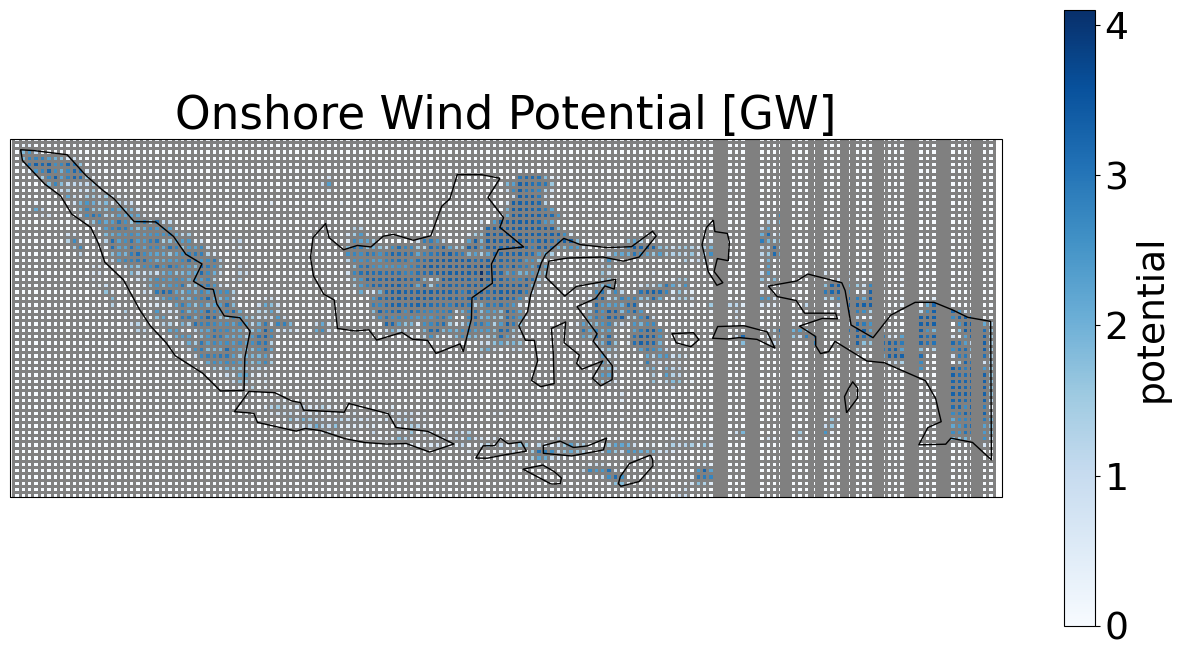

In [24]:
plot_raster(
    wind.potential,
    [country],
    cmap="Blues",
    figsize=(16, 8),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Onshore Wind Potential [GW]",
    # filename="rasterized-onshore-wind-potential.pdf"
)

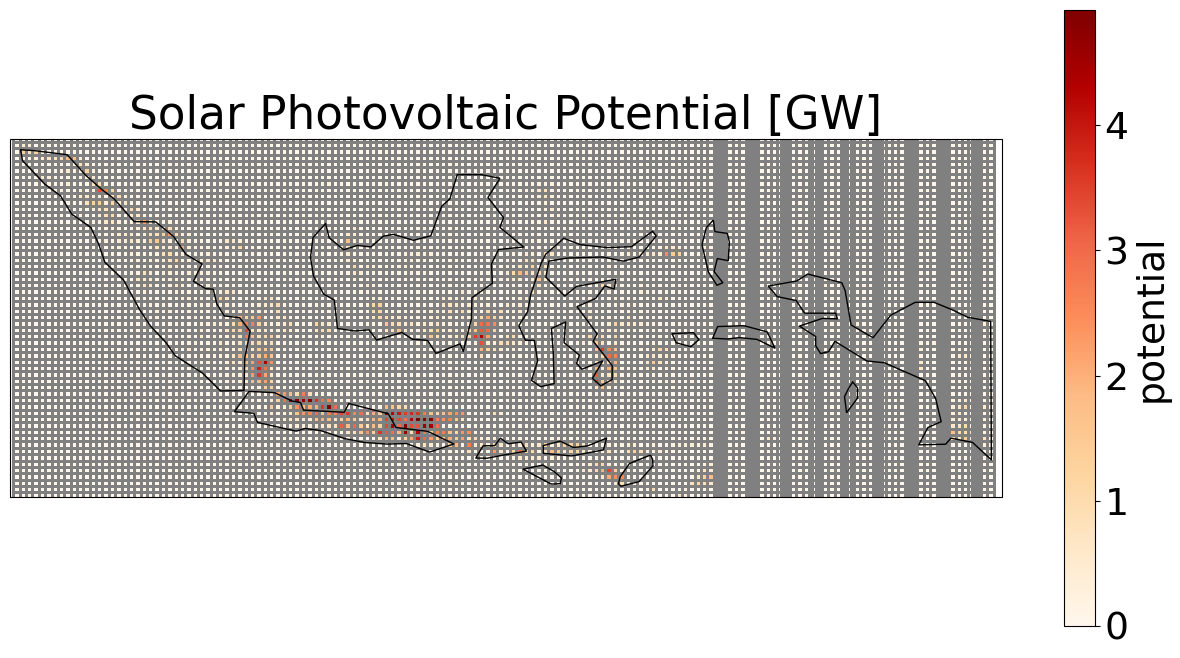

In [25]:
plot_raster(
    solar.potential,
    [country],
    cmap="OrRd",
    figsize=(16, 8),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Solar Photovoltaic Potential [GW]",
    # filename="rasterized-solvar-pv-potential.pdf"
)

Text(0.5, 1.0, '')

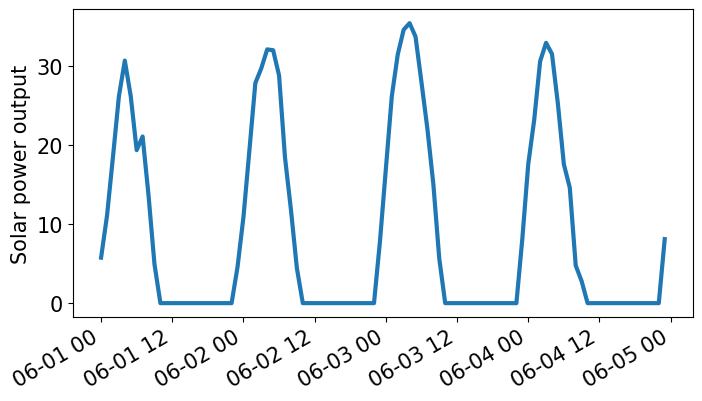

In [26]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
solar_profile_mw = solar["p_nom_max"] * solar["profile"]

solar_profile_mw.sel(bus="0", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Solar power output")
ax.set_title(None)

# plt.savefig("solar-power-profile.pdf", bbox_inches="tight")

KeyError: "not all values found in index 'bus'. Try setting the `method` keyword argument (example: method='nearest')."

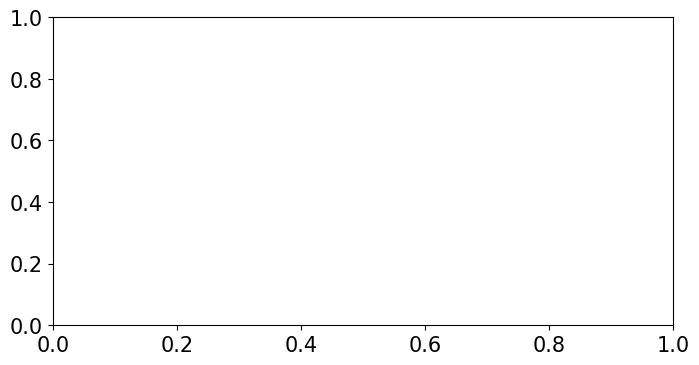

In [27]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
wind_profile_mw = wind["p_nom_max"] * wind["profile"]

wind_profile_mw.sel(bus="01", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Wind power output [MW]")
ax.set_title(None)

# plt.savefig("onshore-wind-power-profile.pdf", bbox_inches="tight")

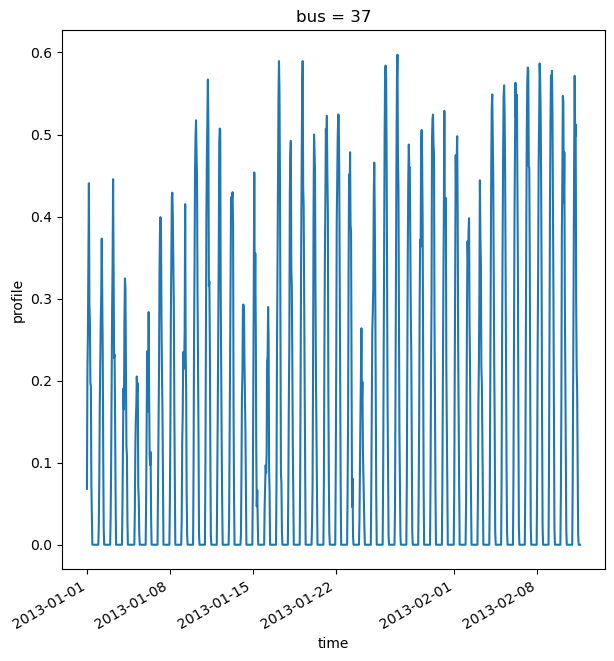

In [28]:
plt.rcParams.update({"font.size": 10})
solar["profile"].isel(bus=sum(range(8)), time=range(0, 1000)).plot()

In [29]:
# Paths of build shapes
# path of the country shapes
path_country_shapes = shapes + "country_shapes.geojson"
# path of the off shore shapes
path_off_shore_shapes = shapes + "offshore_shapes.geojson"
# path of the gadm shapes
path_gadm_shapes = shapes + "gadm_shapes.geojson"

# Path of the OSM data
# raw OSM substation data
path_raw_substations = resources + "osm/raw/all_raw_substations.geojson"
# raw OSM lines data
path_raw_lines = resources + "osm/raw/all_raw_lines.geojson"

# network paths
path_cluster_network = "pypsa-earth/networks/elec_s_10.nc"
# solve network output
solved_network_path = "pypsa-earth/results/networks/elec_s_10_ec_lcopt_Co2L-12H.nc"

# Images setups
max_width_image = 30
max_height_image = 30
dpi = 300

In [30]:
def calculate_width_height_image(
    width_image, height_image, max_width=max_width_image, max_height=max_height_image
):
    """
    Function to identify the width and height of an image to plot
    while keeping the proportions of the image
    """
    if width_image / height_image >= max_width / max_height:
        # image width is the limiting factor
        return (max_width, max_width / width_image * height_image)
    else:
        # image height is the limiting factor
        return (max_height / height_image * width_image, max_height)

In [31]:
# gadm file imports
countries = gpd.read_file(path_country_shapes)
off_shore = gpd.read_file(path_off_shore_shapes)
gadm = gpd.read_file(path_gadm_shapes)

# OSM data imports
df_substations_osm_raw = gpd.read_file(path_raw_substations)
df_lines_osm_raw = gpd.read_file(path_raw_lines)

# # network imports
# # cluster network
# n_c = pypsa.Network(path_cluster_network)
# # solved network
# n_solve = pypsa.Network(solved_network_path)


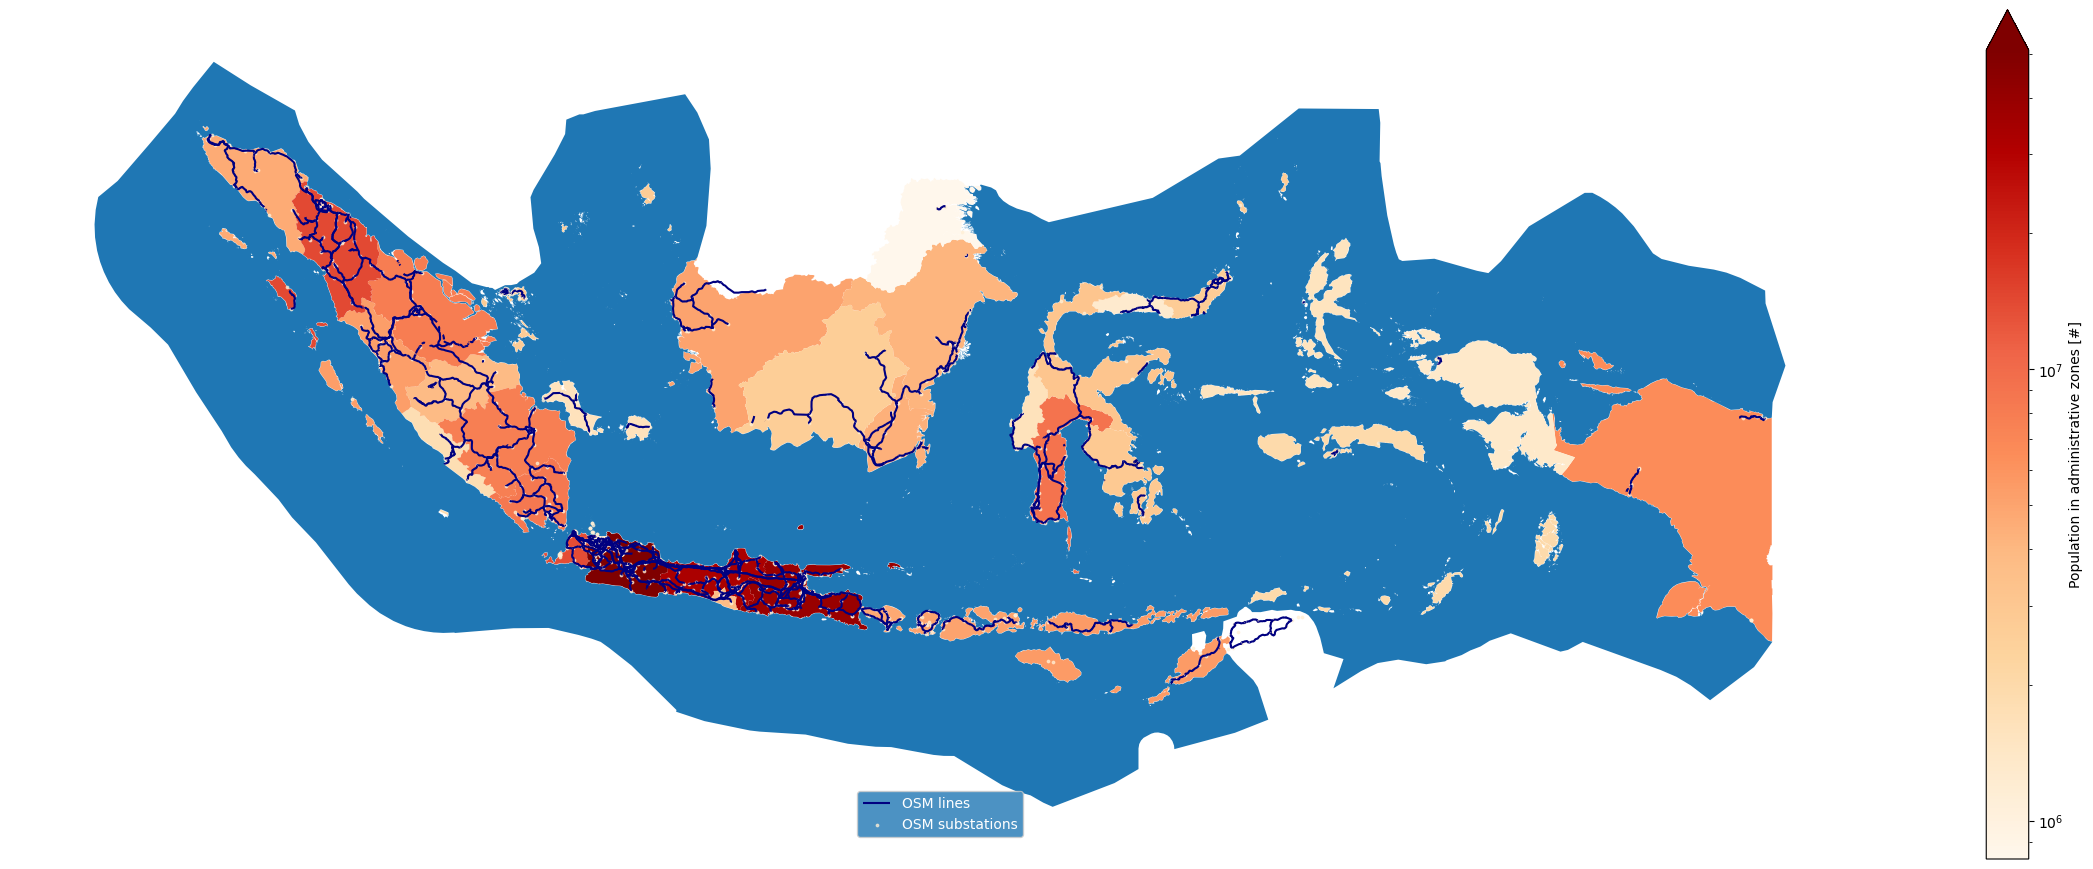

In [32]:
total_bounds_countries = countries.total_bounds
delta_bounds_xy = (
    total_bounds_countries[2] - total_bounds_countries[0],  # maxx - minx
    total_bounds_countries[3] - total_bounds_countries[1],
)  # maxy - miny

size_image = calculate_width_height_image(*delta_bounds_xy)

ax2 = gadm.plot(
    column="pop",
    cmap="OrRd",
    figsize=size_image,
    legend=True,
    label=None,
    norm=matplotlib.colors.LogNorm(
        vmin=gadm["pop"].min() + 1, vmax=gadm["pop"].max(), clip=True
    ),
    legend_kwds={"extend": "max", "label": "Population in administrative zones [#]"},
)  # column="pop",
off_shore.plot(ax=ax2, label=None)  # "offshore")
df_lines_osm_raw.plot(ax=ax2, color="navy", label="OSM lines")
df_substations_osm_raw.plot(
    ax=ax2, color="papayawhip", label="OSM substations", alpha=0.7, markersize=3
)

legend = plt.legend(
    frameon=1, loc="lower center", labelcolor="white", facecolor="tab:blue"
)

plt.axis("off")
plt.savefig("continent_image.png", dpi=dpi, bbox_inches="tight")

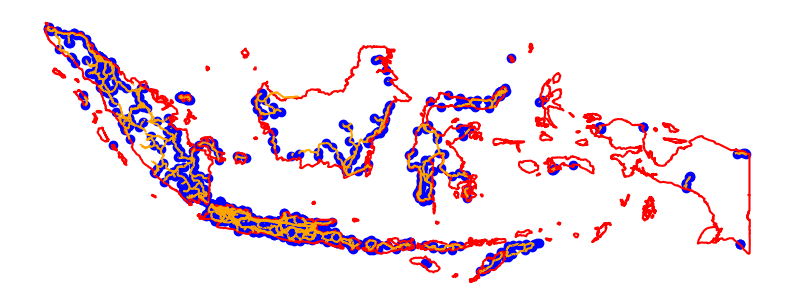

In [33]:
ax = countries.boundary.plot(figsize=(10, 10), color="red")
# off_shore.plot(ax=ax)
df_substations_osm_raw.plot(ax=ax, color="blue")
df_lines_osm_raw.plot(ax=ax, color="orange")
plt.axis("off")
plt.savefig("border_osm_total.png", dpi=dpi)